# Project 4: Movie Recommender System

On this page we will build two recommendation systems for movies. One take a genre as input and the other is more complex and takes a vector of ratings from a user, applying IBCF.

Authors: MCS-DS students Jonas Jansen (jonasj2), Soumya Nanda (srnanda2) and Noam Isachar
(noami2).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

pd.set_option('display.precision', 7)
warnings.filterwarnings('ignore')

DATA_PATH = 'data'

## Import and Preprocess Data

There are three data files. We will save each one of them to a separate dataframe and have a glance at the data they hold.

In [2]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.dat'), 
                        sep='::', header=None, engine='python', encoding='latin-1', 
                        names=['movie_id', 'title', 'genre'])
movies_df['genre'] = movies_df['genre'].str.split('|')
movies_df['year'] = movies_df['title'].str[-5:-1].astype('int64')
movies_df

,movie_id,title,genre,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],2000
3879,3949,Requiem for a Dream (2000),[Drama],2000
3880,3950,Tigerland (2000),[Drama],2000
3881,3951,Two Family House (2000),[Drama],2000


In [3]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.dat'), 
                        sep='::', header=None, engine='python', encoding='latin-1', 
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [4]:
users_df = pd.read_csv(os.path.join(DATA_PATH, 'users.dat'), 
                        sep='::', header=None, engine='python', encoding='latin-1', 
                        names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
users_df = users_df.drop('zip_code', axis=1)
occupation_map = {
    0: 'other', 
    1: 'academic/educator',
    2: 'artist',
    3: 'clerical/admin',
    4: 'college/grad student',
    5: 'customer service',
    6: 'doctor/health care',
    7: 'executive/managerial',
    8: 'farmer',
    9: 'homemaker',
    10: 'K-12 student',
    11: 'lawyer',
    12: 'programmer',
    13: 'retired',
    14: 'sales/marketing',
    15: 'scientist',
    16: 'self-employed',
    17: 'technician/engineer',
    18: 'tradesman/craftsman',
    19: 'unemployed',
    20: 'writer'
    }
age_map = {
    1: 'under 18',
    18:  '18-24',
    25:  '25-34',
    35:  '35-44',
    45:  '45-49',
    50:  '50-55',
    56:  '56+'
    } 
users_df['occupation'] = users_df['occupation'].map(occupation_map)
users_df['age'] = users_df['age'].map(age_map)
users_df

,user_id,gender,age,occupation
0,1,F,under 18,K-12 student
1,2,M,56+,self-employed
2,3,M,25-34,scientist
3,4,M,45-49,executive/managerial
4,5,M,25-34,writer
...,...,...,...,...
6035,6036,F,25-34,scientist
6036,6037,F,45-49,academic/educator
6037,6038,F,56+,academic/educator
6038,6039,F,45-49,other


## Visualizations

Let's have a quick look at some visualizations of the data. We can start with the different genres of movies and see how they distribute and how they are rated.

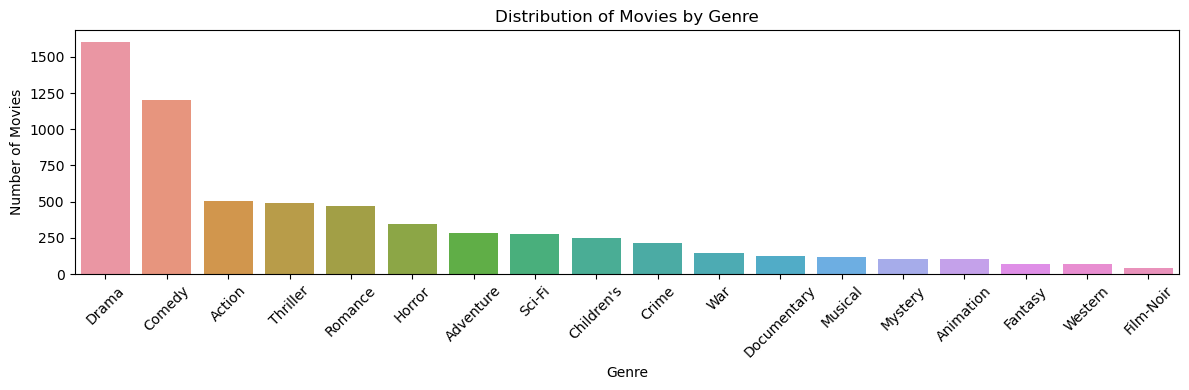

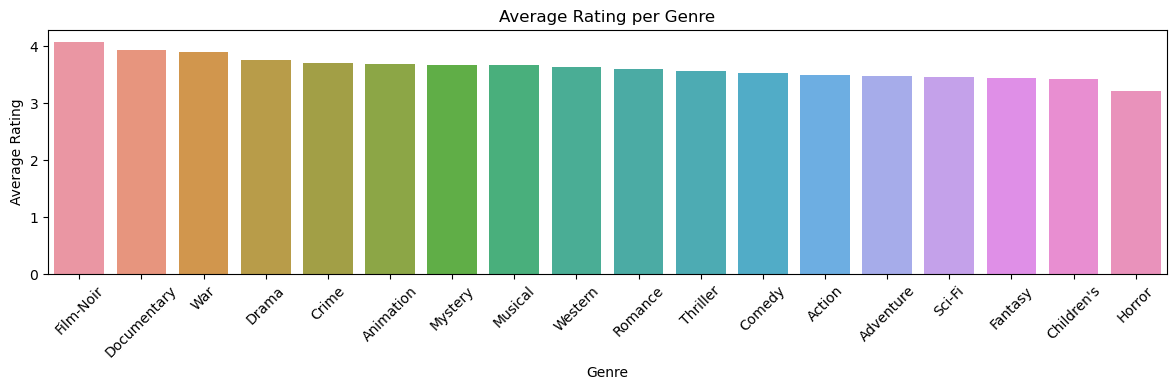

In [5]:
exploded_movies_df = movies_df.explode('genre')

plt.figure(figsize=(12, 4))
sns.countplot(data=exploded_movies_df, x='genre', order=exploded_movies_df['genre'].value_counts().index)
plt.title('Distribution of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

merged_df = pd.merge(exploded_movies_df, ratings_df, on='movie_id', how='inner')
avg_rating_per_genre = merged_df.groupby('genre')['rating'].mean().reset_index()

plt.figure(figsize=(12, 4))
sns.barplot(data=avg_rating_per_genre, x='genre', y='rating', order=avg_rating_per_genre.sort_values('rating', ascending=False)['genre'])
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Film-Noir movies are the least frequent but highest rated movies. In general we see that the more serious genres such as War, Drame and Crime are rated higher than the lighter ones like Fantasy, Comedy and Action. People appreciate movies that make them feel something more. Also we see Horror rated last with a big difference from the rest. Well deserved.

Now let's split the users using the different categories: Gender, Age and Occupation and see how they rate movies. 

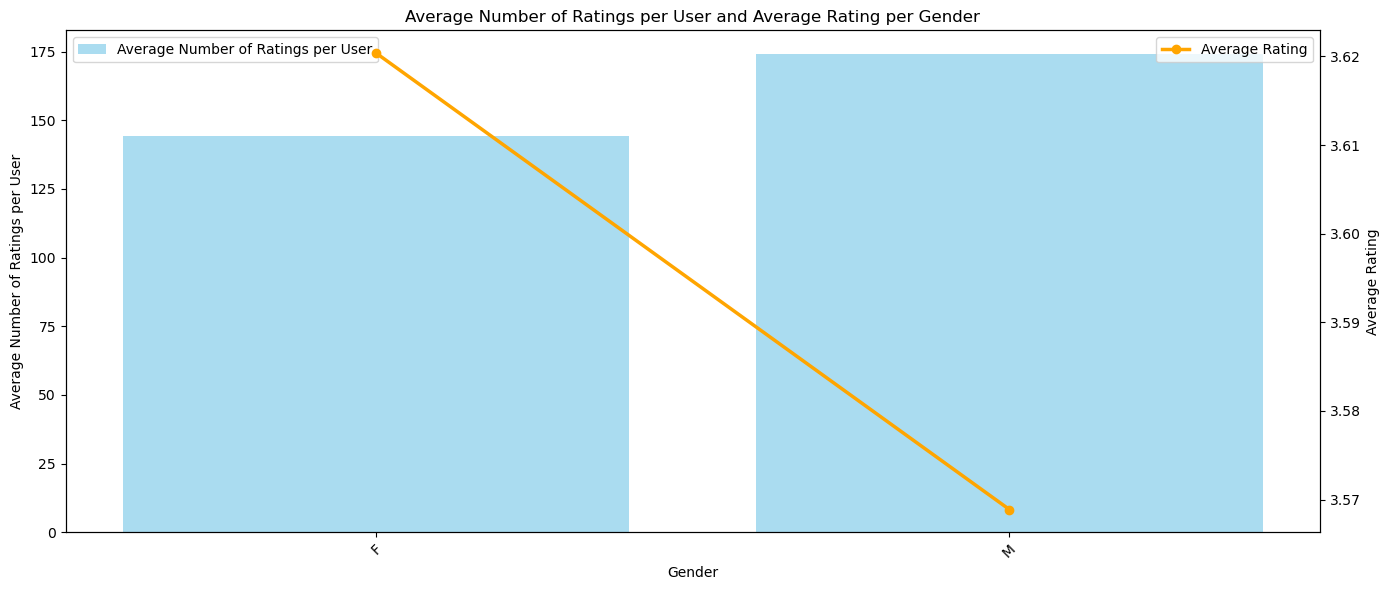

In [6]:
merged_df = pd.merge(ratings_df, users_df, on='user_id', how='inner')

user_rating_counts = merged_df.groupby('user_id')['rating'].count().reset_index()
user_rating_counts.columns = ['user_id', 'num_ratings']

user_info_with_ratings = pd.merge(user_rating_counts, users_df, on='user_id', how='inner')
gender_stats = user_info_with_ratings.groupby('gender').agg({'num_ratings': 'mean'}).reset_index()
gender_stats.columns = ['gender', 'mean_ratings_per_user']

plt.figure(figsize=(14, 6))
plt.bar(gender_stats['gender'], gender_stats['mean_ratings_per_user'], color='skyblue', alpha=0.7, label='Average Number of Ratings per User')
plt.ylabel('Average Number of Ratings per User')
plt.xlabel('Gender')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

avg_rating_per_gender = merged_df.groupby('gender')['rating'].mean().reset_index()

ax2 = plt.gca().twinx()
ax2.plot(avg_rating_per_gender['gender'], avg_rating_per_gender['rating'], marker='o', color='orange', linewidth=2.5, label='Average Rating')
ax2.set_ylabel('Average Rating')
ax2.legend(loc='upper right')

plt.title('Average Number of Ratings per User and Average Rating per Gender')
plt.tight_layout()
plt.show()

Men are slightly more critical then women and are also more dedicated to reviewing movies.

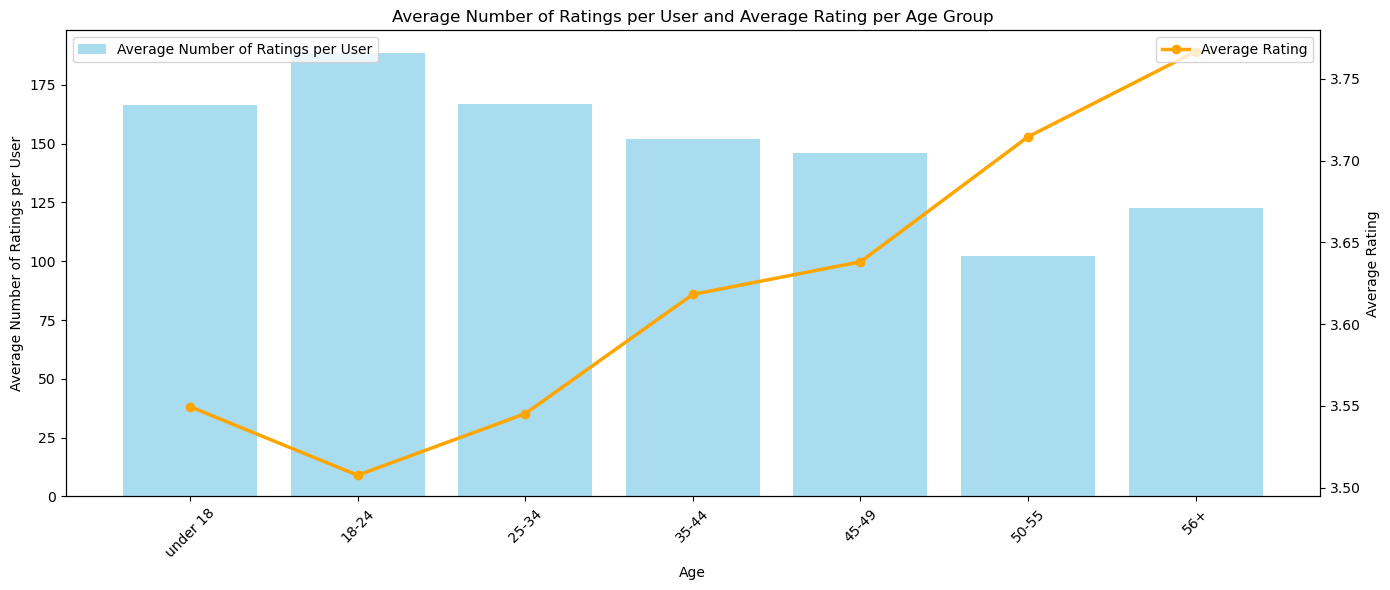

In [7]:
user_rating_counts = merged_df.groupby('user_id')['rating'].count().reset_index()
user_rating_counts.columns = ['user_id', 'num_ratings']

# Merge user rating counts with users_df to get age information
user_info_with_ratings = pd.merge(user_rating_counts, users_df, on='user_id', how='inner')

# Group by age and calculate the mean of ratings per user for each age group
age_stats = user_info_with_ratings.groupby('age').agg({'num_ratings': 'mean'}).reset_index()
age_stats.columns = ['age', 'mean_ratings_per_user']

plt.figure(figsize=(14, 6))

plt.bar(age_stats['age'], age_stats['mean_ratings_per_user'], color='skyblue', alpha=0.7, label='Average Number of Ratings per User')
plt.ylabel('Average Number of Ratings per User')
plt.xlabel('Age')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Assuming 'ratings_df' contains the ratings data
avg_rating_per_age = merged_df.groupby('age')['rating'].mean().reset_index()
avg_rating_per_age = avg_rating_per_age.sort_values('age', key=lambda x: x.map({'under 18': 0, '18-24': 1, '25-34': 3, '35-44': 4, '45-49': 5, '50-55': 6, '56+': 7}))

ax2 = plt.gca().twinx()
ax2.plot(avg_rating_per_age['age'], avg_rating_per_age['rating'], marker='o', color='orange', linewidth=2.5, label='Average Rating')
ax2.set_ylabel('Average Rating')
ax2.legend(loc='upper right')

plt.title('Average Number of Ratings per User and Average Rating per Age Group')
plt.tight_layout()
plt.show()

As expected, younger people review more. Together with that we see a nicely increasing trend in the average rating as the age goes up. Maybe younger people got used to the good stuff.

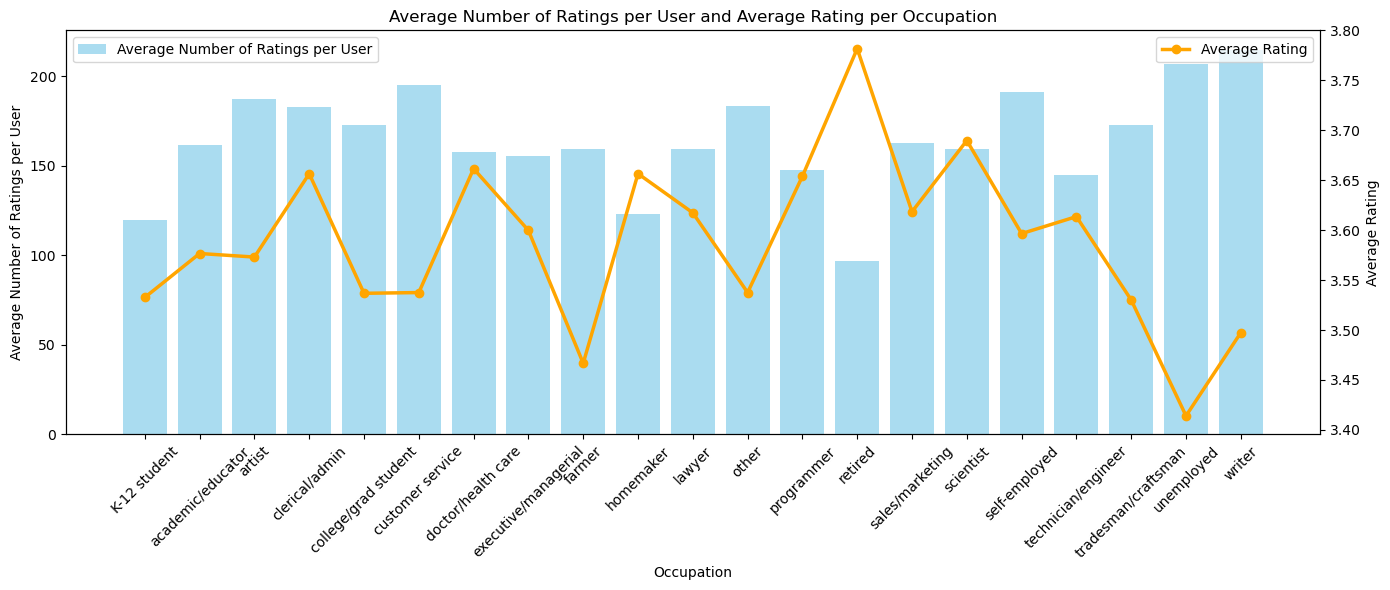

In [8]:
user_rating_counts = merged_df.groupby('user_id')['rating'].count().reset_index()
user_rating_counts.columns = ['user_id', 'num_ratings']

user_info_with_ratings = pd.merge(user_rating_counts, users_df, on='user_id', how='inner')

occupation_stats = user_info_with_ratings.groupby('occupation').agg({'num_ratings': 'mean'}).reset_index()
occupation_stats.columns = ['occupation', 'mean_ratings_per_user']

plt.figure(figsize=(14, 6))
plt.bar(occupation_stats['occupation'], occupation_stats['mean_ratings_per_user'], color='skyblue', alpha=0.7, label='Average Number of Ratings per User')
plt.ylabel('Average Number of Ratings per User')
plt.xlabel('Occupation')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

avg_rating_per_occupation = merged_df.groupby('occupation')['rating'].mean().reset_index()

ax2 = plt.gca().twinx()
ax2.plot(avg_rating_per_occupation['occupation'], avg_rating_per_occupation['rating'], marker='o', color='orange', linewidth=2.5, label='Average Rating')
ax2.set_ylabel('Average Rating')
ax2.legend(loc='upper right')

plt.title('Average Number of Ratings per User and Average Rating per Occupation')
plt.tight_layout()
plt.show()

There are a few interesting  findings here. Retired people rate movies very high which correlates with the increase in the average rating we saw when the age increases. Unemployed and writers review the most movies and they are also the least content together with farmers. Finally, scientist seem to be very happy with what they see.

Let's continue with the splits by user categories but now look at the average rating per genre. 

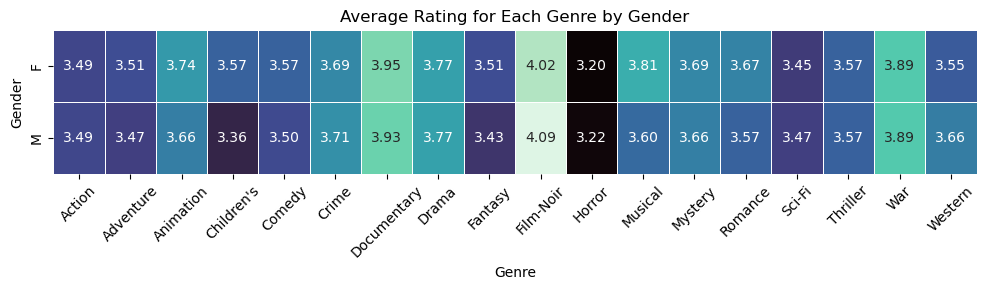

In [9]:
merged_df = pd.merge(ratings_df, users_df, on='user_id', how='inner')
merged_df = pd.merge(merged_df, exploded_movies_df, on='movie_id', how='inner')

gender_genre_avg_rating = merged_df.groupby(['gender', 'genre'])['rating'].mean().reset_index()
gender_genre_pivot = gender_genre_avg_rating.pivot(index='gender', columns='genre', values='rating')
gender_genre_pivot['Total'] = gender_genre_pivot.mean(axis=1)
gender_genre_pivot.drop('Total', axis=1, inplace=True)

plt.figure(figsize=(10, 3))
sns.heatmap(gender_genre_pivot, cmap='mako', annot=True, fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Average Rating for Each Genre by Gender')
plt.xlabel('Genre')
plt.ylabel('Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we see the reasons for the lower average rating in men reviews. We can point the finger at children's movies, animations, fantasies, comedies and musical. The only genre where there is a big difference in favor of men is westerns.

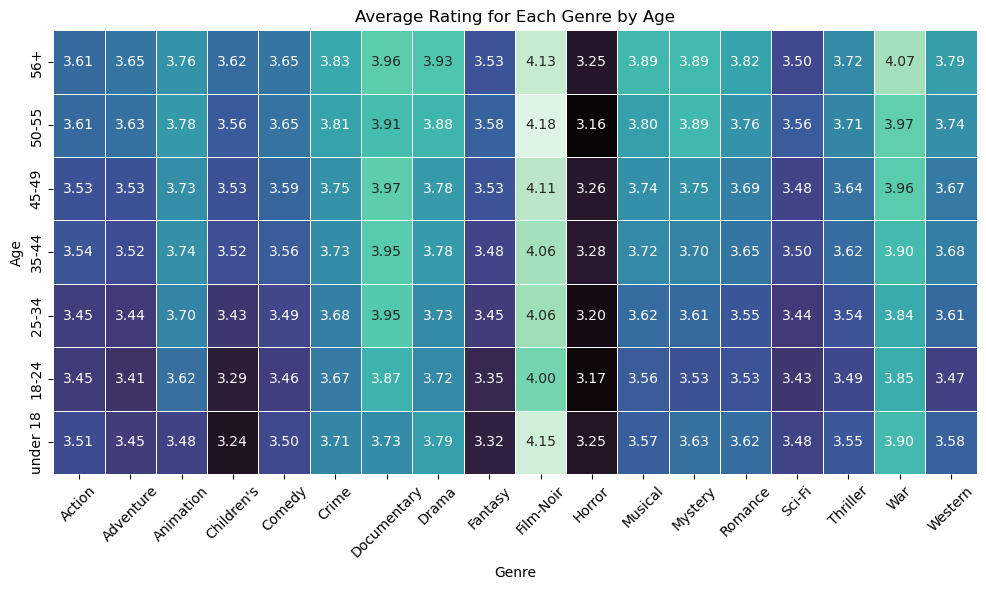

In [10]:
age_genre_avg_rating = merged_df.groupby(['age', 'genre'])['rating'].mean().reset_index()
age_genre_pivot = age_genre_avg_rating.pivot(index='age', columns='genre', values='rating')
age_genre_pivot['Total'] = age_genre_pivot.mean(axis=1)
age_genre_pivot = age_genre_pivot.sort_values('age', key=lambda x: x.map({'under 18': 0, '18-24': 1, '25-34': 3, '35-44': 4, '45-49': 5, '50-55': 6, '56+': 7}), ascending=False)
age_genre_pivot.drop('Total', axis=1, inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(age_genre_pivot, cmap='mako', annot=True, fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Average Rating for Each Genre by Age')
plt.xlabel('Genre')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Surprisingly, the youngest people don't seem to enjoy animations, musicals and children's movies compared to other age groups. Rebels. 

In fact, children's movies average rating strictly increases as the age goes up. The older generation also appreciates war movies... but dramas and mysteries as well.

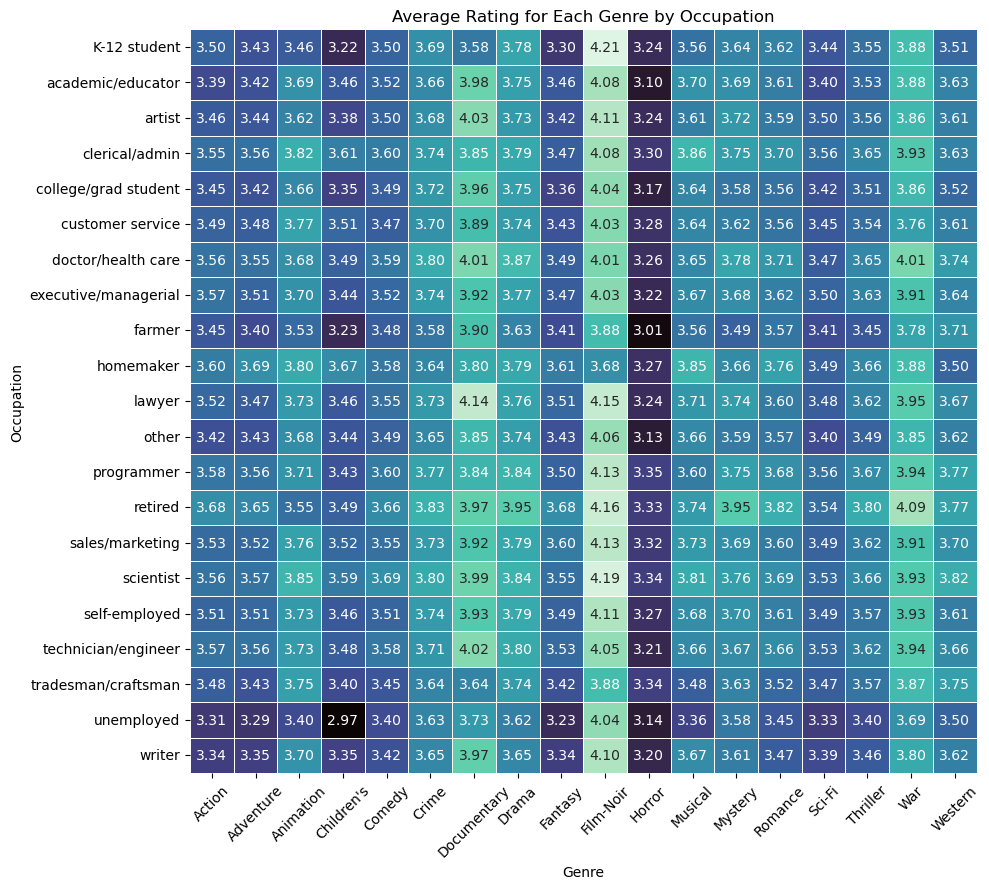

In [11]:
occupation_genre_avg_rating = merged_df.groupby(['occupation', 'genre'])['rating'].mean().reset_index()
occupation_genre_pivot = occupation_genre_avg_rating.pivot(index='occupation', columns='genre', values='rating')
occupation_genre_pivot['Total'] = occupation_genre_pivot.mean(axis=1)
occupation_genre_pivot.drop('Total', axis=1, inplace=True)

plt.figure(figsize=(10, 9))
sns.heatmap(occupation_genre_pivot, cmap='mako', annot=True, fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Average Rating for Each Genre by Occupation')
plt.xlabel('Genre')
plt.ylabel('Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the huge heatmap above there are a few interesting takeaways. Unemployed are quite salty towards children's movies and animations while lawyers adore documentaries. Retired people are fascinated about mysteries and war movies which also interest doctors. Homemakers and clercs especially enjoy musicals, which highlights the big portion of women in these occupations. Farmers are the biggest adversaries of horror movies while scientist enjoy westerns, comedies and animations more than the rest.

## System I: Recommendation Based on Genres

In the case that we want to recommend a number of movies from a specific genre we can think of some different approaches. The most frequent ones are to take the most popular movies, meaning the ones with the most ratings, or the highest rated movies (with some threshold for the number of ratings). We decided to go with a hybrid approach that combines the number of ratings and the average rating.

This hybrid approach was selected as it combines the strengths of both popularity and average rating, offering a more comprehensive and balanced recommendation strategy. By integrating these factors through a weighted scoring system we consider both widespread appeal and individual preferences. This approach strives to overcome limitations of singular methods by delivering more accurate and diverse suggestions.

For each movie we will save the number of ratings it has and the average rating, and we also need to decide on the weight for each factor. For general recommendations that don't take personal ratings of a specific user we think it's more appropriate to give the popularity more weight, so we decided to go with 0.6 for the number of ratings and 0.4 for the average rating. Using these weights we can calculate the score of each movie and for each genre return the N highest scoring movies. One important thing to note is that before doing the weighted average between the popularity and average rating we need to normalize the two in order to not let number of ratings overshadow the average rating.

In [12]:
number_of_ratings = ratings_df.groupby('movie_id')['rating'].count()
average_rating = ratings_df.groupby('movie_id')['rating'].mean()

movies_df = pd.merge(movies_df, number_of_ratings, left_on='movie_id', right_index=True, how='left')
movies_df = movies_df.rename(columns={'rating': 'number_of_ratings'})
movies_df = pd.merge(movies_df, average_rating, left_on='movie_id', right_index=True, how='left')
movies_df = movies_df.rename(columns={'rating': 'average_rating'})

movies_df

,movie_id,title,genre,year,number_of_ratings,average_rating
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,2077.0,4.1468464
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995,701.0,3.2011412
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,478.0,3.0167364
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995,170.0,2.7294118
4,5,Father of the Bride Part II (1995),[Comedy],1995,296.0,3.0067568
...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],2000,862.0,3.6357309
3879,3949,Requiem for a Dream (2000),[Drama],2000,304.0,4.1151316
3880,3950,Tigerland (2000),[Drama],2000,54.0,3.6666667
3881,3951,Two Family House (2000),[Drama],2000,40.0,3.9000000


In [13]:
normalized_number_of_ratings = (movies_df['number_of_ratings'] - movies_df['number_of_ratings'].min()) / (movies_df['number_of_ratings'].max() - movies_df['number_of_ratings'].min())
normalized_average_rating = (movies_df['average_rating'] - movies_df['average_rating'].min()) / (movies_df['average_rating'].max() - movies_df['average_rating'].min())

popularity_weight = 0.6
ratings_weight = 0.4

hybrid_score = (normalized_number_of_ratings * popularity_weight) + (normalized_average_rating * ratings_weight)
movies_df['hybrid_score'] = hybrid_score

movies_df

,movie_id,title,genre,year,number_of_ratings,average_rating,hybrid_score
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,2077.0,4.1468464,0.6781512
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995,701.0,3.2011412,0.3426703
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,478.0,3.0167364,0.2851869
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995,170.0,2.7294118,0.2025297
4,5,Father of the Bride Part II (1995),[Comedy],1995,296.0,3.0067568,0.2523243
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],2000,862.0,3.6357309,0.4143172
3879,3949,Requiem for a Dream (2000),[Drama],2000,304.0,4.1151316,0.3645625
3880,3950,Tigerland (2000),[Drama],2000,54.0,3.6666667,0.2759459
3881,3951,Two Family House (2000),[Drama],2000,40.0,3.9000000,0.2968281


Let's check the top 10 movies based on our hybrid metric.

In [14]:
movies_df.nlargest(10, 'hybrid_score')

,movie_id,title,genre,year,number_of_ratings,average_rating,hybrid_score
2789,2858,American Beauty (1999),"[Comedy, Drama]",1999,3428.0,4.3173862,0.9317386
257,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy, Sci-Fi]",1977,2991.0,4.4536944,0.8688594
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Drama, Sci-Fi, War]",1980,2990.0,4.2929766,0.8526125
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),"[Action, Adventure, Romance, Sci-Fi, War]",1983,2883.0,4.0228928,0.8068705
1959,2028,Saving Private Ryan (1998),"[Action, Drama, War]",1998,2653.0,4.3373539,0.7980482
1180,1198,Raiders of the Lost Ark (1981),"[Action, Adventure]",1981,2514.0,4.4777247,0.7877491
589,593,"Silence of the Lambs, The (1991)","[Drama, Thriller]",1991,2578.0,4.3518231,0.7863641
2502,2571,"Matrix, The (1999)","[Action, Sci-Fi, Thriller]",1999,2590.0,4.3158301,0.7848658
2693,2762,"Sixth Sense, The (1999)",[Thriller],1999,2459.0,4.4062627,0.7709735
585,589,Terminator 2: Judgment Day (1991),"[Action, Sci-Fi, Thriller]",1991,2649.0,4.0585126,0.7694638


Now for some specific genres.

In [15]:
exploded_movies_df = movies_df.explode('genre')
exploded_movies_df[exploded_movies_df['genre'] == 'Drama'].nlargest(10, 'hybrid_score')

,movie_id,title,genre,year,number_of_ratings,average_rating,hybrid_score
2789,2858,American Beauty (1999),Drama,1999,3428.0,4.3173862,0.9317386
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Drama,1980,2990.0,4.2929766,0.8526125
1959,2028,Saving Private Ryan (1998),Drama,1998,2653.0,4.3373539,0.7980482
589,593,"Silence of the Lambs, The (1991)",Drama,1991,2578.0,4.3518231,0.7863641
604,608,Fargo (1996),Drama,1996,2513.0,4.2546757,0.7652691
523,527,Schindler's List (1993),Drama,1993,2304.0,4.5104167,0.7542515
108,110,Braveheart (1995),Drama,1995,2443.0,4.2349570,0.7510417
315,318,"Shawshank Redemption, The (1994)",Drama,1994,2227.0,4.5545577,0.7451844
847,858,"Godfather, The (1972)",Drama,1972,2223.0,4.5249663,0.7415249
293,296,Pulp Fiction (1994),Drama,1994,2171.0,4.2782128,0.7077454


In [16]:
exploded_movies_df[exploded_movies_df['genre'] == 'Horror'].nlargest(10, 'hybrid_score')

,movie_id,title,genre,year,number_of_ratings,average_rating,hybrid_score
2647,2716,Ghostbusters (1984),Horror,1984,2181.0,3.9055479,0.6722297
1196,1214,Alien (1979),Horror,1979,2024.0,4.1595850,0.6701458
1366,1387,Jaws (1975),Horror,1975,1697.0,4.0895698,0.6058931
1201,1219,Psycho (1960),Horror,1960,1263.0,4.2185273,0.5428040
1258,1278,Young Frankenstein (1974),Horror,1974,1193.0,4.2506287,0.5337585
1238,1258,"Shining, The (1980)",Horror,1980,1087.0,4.1048758,0.5006247
1928,1997,"Exorcist, The (1973)",Horror,1973,885.0,3.9559322,0.4503642
1197,1215,Army of Darkness (1993),Horror,1993,945.0,3.8042328,0.4456990
2588,2657,"Rocky Horror Picture Show, The (1975)",Horror,1975,1233.0,3.2911598,0.4448148
3012,3081,Sleepy Hollow (1999),Horror,1999,1066.0,3.5168856,0.4381490


In [17]:
exploded_movies_df[exploded_movies_df['genre'] == 'Animation'].nlargest(10, 'hybrid_score')

,movie_id,title,genre,year,number_of_ratings,average_rating,hybrid_score
0,1,Toy Story (1995),Animation,1995,2077.0,4.1468464,0.6781512
3045,3114,Toy Story 2 (1999),Animation,1999,1585.0,4.2189274,0.5992199
2286,2355,"Bug's Life, A (1998)",Animation,1998,1703.0,3.8543746,0.5834240
2918,2987,Who Framed Roger Rabbit? (1988),Animation,1988,1799.0,3.6798221,0.5827765
3682,3751,Chicken Run (2000),Animation,2000,1329.0,3.8796087,0.5204674
584,588,Aladdin (1992),Animation,1992,1351.0,3.7883050,0.5151888
1132,1148,"Wrong Trousers, The (1993)",Animation,1993,882.0,4.5079365,0.5050393
2631,2700,"South Park: Bigger, Longer and Uncut (1999)",Animation,1999,1269.0,3.7604413,0.4980459
360,364,"Lion King, The (1994)",Animation,1994,1121.0,3.8608385,0.4821737
591,595,Beauty and the Beast (1991),Animation,1991,1060.0,3.8858491,0.4739949


Using this metric we think the user gets a good combination between popular "must-see" movies and high quality movies.

## System II: Recommendation Based on IBCF

Personalized recommendation are more complicated to provide than ones based on genre. We will do this by computing the similarity matrix of the movie ratings and then use it to predict which movies a new user will like, given some ratings the new user submitted.

The first step is to create a matrix with users as rows and movies as columns. The values will be the rating each user gave each movie. If a user did not rate a movie we will have NaN there. We also center this matrix by subtracting the row mean from each row.

In [18]:
rating_matrix = ratings_df.pivot_table(index='user_id', columns='movie_id', values='rating')
rating_matrix_centered = rating_matrix.sub(rating_matrix.mean(axis=1), axis=0)

rating_matrix_centered

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.8113208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.1464646,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,-1.3029279,NaN,-0.3029279,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we compute the cosine similarity of each pair of movies. We do it only for movies that have more than 2 rating users in common.

The formula we use is as follows:

$$S_{ij} = \frac{1}{2} + \frac{1}{2} \frac{\sum_{l \in \mathcal{I}_{ij}}
R_{li}{R_{lj}}}{\sqrt{\sum_{l \in \mathcal{I}_{ij}} R_{li}^2}
\sqrt{\sum_{l \in \mathcal{I}_{ij}} R_{lj}^2}}$$

In [19]:
def compute_cosine_similarity(movie_i_ratings, movie_j_ratings):
    # Find users who rated both movies i and j
    users_rated_both = (~np.isnan(movie_i_ratings)) & (~np.isnan(movie_j_ratings))
    
    # Calculate similarity if more than 2 users rated both movies
    if sum(users_rated_both) <= 2:
        return np.nan
    
    # Get ratings of users who rated both movies i and j
    users_both_ratings_i = movie_i_ratings[users_rated_both]
    users_both_ratings_j = movie_j_ratings[users_rated_both]
    
    # Calculate the numerator and denominator for cosine similarity
    numerator = np.dot(users_both_ratings_i, users_both_ratings_j)
    norm_i = np.linalg.norm(users_both_ratings_i)
    norm_j = np.linalg.norm(users_both_ratings_j)
    
    similarity = 0.5 + (numerator / (norm_i * norm_j * 2))
    return similarity

In [21]:
num_movies = len(rating_matrix.columns)
similarity_matrix = np.zeros((num_movies, num_movies))

for i in range(num_movies):
    for j in range(i+1, num_movies):
        movie_i_ratings = rating_matrix_centered[rating_matrix.columns[i]]
        movie_j_ratings = rating_matrix_centered[rating_matrix.columns[j]]
        similarity = compute_cosine_similarity(movie_i_ratings, movie_j_ratings)
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Since cosine similarity is symmetric

np.fill_diagonal(similarity_matrix, 1.0)
similarity_df = pd.DataFrame(similarity_matrix, index=rating_matrix.columns, columns=rating_matrix.columns)
similarity_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.0000000,0.4426358,0.4107656,0.4040198,0.3624566,0.5791682,0.4752569,0.3033785,0.1889663,0.5121055,...,0.3818344,0.0894885,0.2278028,0.2700041,0.6497732,0.5481223,0.7029724,0.5552313,0.7031090,0.6008690
2,0.4426358,1.0000000,0.5467429,0.4604947,0.6480018,0.4120141,0.5714882,0.4886860,0.6896189,0.5415037,...,0.3984206,NaN,0.4414057,0.6854198,0.2614537,0.5539103,0.3234604,0.3165632,0.2234197,0.4213481
3,0.4107656,0.5467429,1.0000000,0.6407562,0.6773827,0.4374527,0.5479598,0.6694070,0.5870297,0.5688345,...,0.4397559,0.4582364,0.3854456,0.7038252,0.5036539,0.5281682,0.2840154,0.5159712,0.4906831,0.4273157
4,0.4040198,0.4604947,0.6407562,1.0000000,0.7101445,0.3189434,0.5130876,0.6384137,0.4940782,0.3691460,...,0.7640841,NaN,NaN,0.9075091,0.3486472,0.4574282,0.1687647,0.6218913,0.6609536,0.4494238
5,0.3624566,0.6480018,0.6773827,0.7101445,1.0000000,0.3889425,0.5879431,0.6086423,0.7584385,0.5035920,...,0.1311948,0.5094581,0.6016905,0.8559123,0.6448522,0.5901651,0.2399825,0.5171044,NaN,0.3477549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.5481223,0.5539103,0.5281682,0.4574282,0.5901651,0.5344822,0.4773167,0.3232607,0.4412754,0.5744124,...,0.4657107,0.5360674,0.4485322,0.5152201,0.3698591,1.0000000,0.4918519,0.4253327,0.3073339,0.5065300
3949,0.7029724,0.3234604,0.2840154,0.1687647,0.2399825,0.6153289,0.3553973,0.1106119,0.2137667,0.4398656,...,0.5631146,0.3012179,0.2525804,0.2952466,0.6576071,0.4918519,1.0000000,0.5940700,0.6565161,0.5662323
3950,0.5552313,0.3165632,0.5159712,0.6218913,0.5171044,0.4190513,0.6490629,0.7967708,NaN,0.5899691,...,0.4806075,0.2336521,0.0206601,0.5024945,0.5328135,0.4253327,0.5940700,1.0000000,0.6625016,0.5737278


In order to reduce the size of the matrix we keep only the top 30 similarites of each movie, each row. We don't include each movie's similarity with itself since it doesn't help us when trying to recommend movies a user did not watch.

In [22]:
def keep_top_30(matrix):
    np.fill_diagonal(matrix, np.nan)
    nan_mask = np.isnan(matrix)
    top_30_indices = np.argsort(np.where(nan_mask, -np.inf, matrix), axis=1)[:, -30:]
    
    result = np.full_like(matrix, np.nan)
    rows = np.arange(matrix.shape[0])[:, None]
    
    result[rows, top_30_indices] = matrix[rows, top_30_indices]
    result[nan_mask] = np.nan
    
    return result

In [23]:
top_30_similarity_matrix = keep_top_30(similarity_matrix.copy())
top_30_similarity_df = pd.DataFrame(top_30_similarity_matrix, index=rating_matrix.columns, columns=rating_matrix.columns)

Let's have a look at some pairwaise similarities. We will do it for the full matrix and then for the top 30 matrix.

In [24]:
def print_pairwise_similarity(df, selected_rows):
    filtered_df = df.loc[selected_rows, selected_rows]
    
    print("Pairwise similarities for selected movies:")
    print(filtered_df)
    print("------------")

print_pairwise_similarity(similarity_df, [1, 10, 100, 1510, 260, 3212])
print_pairwise_similarity(top_30_similarity_df, [1, 10, 100, 1510, 260, 3212])

Pairwise similarities for selected movies:
movie_id       1          10         100   1510       260   3212
movie_id                                                        
1         1.0000000  0.5121055  0.3919999   NaN  0.7411482   NaN
10        0.5121055  1.0000000  0.5474583   NaN  0.5343338   NaN
100       0.3919999  0.5474583  1.0000000   NaN  0.3296943   NaN
1510            NaN        NaN        NaN   1.0        NaN   NaN
260       0.7411482  0.5343338  0.3296943   NaN  1.0000000   NaN
3212            NaN        NaN        NaN   NaN        NaN   1.0
------------
Pairwise similarities for selected movies:
movie_id  1     10    100   1510  260   3212
movie_id                                    
1          NaN   NaN   NaN   NaN   NaN   NaN
10         NaN   NaN   NaN   NaN   NaN   NaN
100        NaN   NaN   NaN   NaN   NaN   NaN
1510       NaN   NaN   NaN   NaN   NaN   NaN
260        NaN   NaN   NaN   NaN   NaN   NaN
3212       NaN   NaN   NaN   NaN   NaN   NaN
------------


The final step is to create the function that given ratings of a new user it will generate recommendations of 10 movies not watched (or at least not rated) by the new user. The way to do it is to give a prediction for each unrated movie using the ratings the new user provided on the top 30 similar movies of the unrated movie. Here is the formula:

$$\frac{1}{\sum_{i \in S(l)} S_{li} \mathbf{1}_{\{w_i \ne NA\}}} \sum_{i
\in S(l) } S_{li} w_{i}$$

There might be cases where the new user did not rate many movies so using this formula we are unable to recommend 10 movies, so we are going to need a method to complete the list to 10 recommendations. We decided to do it using the hybrid score from System I which combines rating and popularity. We will take the genre of the highest rated movie by the new user, and complete the list with the ones that have the highest hybris score from that genre, not including movies the user has already watched.

In [118]:
def my_ibcf(newuser, similarity_matrix, rating_matrix, exploded_movies_df):
    # Find indices of unrated movies by the new user
    unrated_indices = np.where(np.isnan(newuser))[0]
    rated_indices = np.where(~np.isnan(newuser))[0]
    
    predictions = []
    for l in unrated_indices:
        # Find the 30 most similar movies to the unrated movie l
        neighborhood = np.intersect1d(np.where(~np.isnan(similarity_matrix[l, :]))[0], rated_indices)
        
        # Calculate the predicted rating for the unrated movie l using collaborative filtering
        numerator = np.dot(similarity_matrix[l, neighborhood], newuser[neighborhood])
        denominator = np.sum(similarity_matrix[l, neighborhood])
        
        if denominator != 0:
            prediction = numerator / denominator
            predictions.append((l, prediction))
    
    # Sort the predictions based on predicted ratings in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Select the top 10 movies with the highest predicted ratings (excluding NaN predictions)
    top_10_recommendations = [movie for movie, prediction in predictions[:10] if not np.isnan(prediction)]
    
    # Get movie names based on the indices and return recommended movies
    top_10_recommendations = rating_matrix.columns[top_10_recommendations].values.tolist()
    
    # If less than 10 recommendations are available, complete recommendations using 'complete_my_ibcf'
    if len(top_10_recommendations) < 10:
        genre_recommendations = complete_my_ibcf(newuser, exploded_movies_df, rating_matrix)
        
        # Remove movies that have already been recommended by the similarity predictions 
        genre_recommendations = list(set(genre_recommendations) - set(top_10_recommendations))
        # Complete the recommendations with the required amount of movies
        top_10_recommendations = top_10_recommendations + genre_recommendations[:10-len(top_10_recommendations)]
    
    return top_10_recommendations

def complete_my_ibcf(newuser, exploded_movies_df, rating_matrix):
    # Get the index of the highest rated movie in the new user's ratings and if there are no ratings at all we set to nan
    try:
        highest_rated_movie_id = rating_matrix.columns[np.nanargmax(newuser)]
    except ValueError:
        highest_rated_movie_id = np.nan
    
    if not np.isnan(highest_rated_movie_id):
        highest_rated_movie_id = rating_matrix.columns[np.nanargmax(newuser)]
        # Find the genre of the highest rated movie
        genre_of_highest_rated_movie = exploded_movies_df.loc[exploded_movies_df['movie_id'] == highest_rated_movie_id, 'genre'].values[0]
        
        # Filter movies with the same genre as the highest rated movie
        movies_same_genre = exploded_movies_df[exploded_movies_df['genre'] == genre_of_highest_rated_movie]
        
        # Remove movies rated by the new user
        rated_indices = np.where(~np.isnan(newuser))[0]
        rated_movie_ids = rating_matrix.columns[rated_indices].values
        movies_same_genre = movies_same_genre[~movies_same_genre['movie_id'].isin(rated_movie_ids)]
        
        # Find the movies with the largest hybrid_score among the same genre movies
        return movies_same_genre.nlargest(10, 'hybrid_score')['movie_id'].tolist()
        
    # If there are no ratings at all we return the top 10 movies based on hybrid score
    else:
        return exploded_movies_df.drop_duplicates(subset='movie_id', keep='first').nlargest(10, 'hybrid_score')['movie_id'].tolist()

Let's test the IBCF function with some existing users and a new one. The outputted numbers are the movie ids of the recommendations.

In [85]:
my_ibcf(rating_matrix.loc[1181].values, top_30_similarity_df.values, rating_matrix, exploded_movies_df)

array([3732,  749, 3899,  249,  337,  427,  504, 1039, 1235, 1253],
      dtype=int64)

In [27]:
my_ibcf(rating_matrix.loc[1351].values, top_30_similarity_df.values, rating_matrix, exploded_movies_df)

array([1780, 1871, 1901, 2061,  106,  318,  404,  457,  560,  645],
      dtype=int64)

In [28]:
user = pd.Series(index=rating_matrix.columns)
user[1613] = 5
user[1755] = 4
my_ibcf(user.values, top_30_similarity_df.values, rating_matrix, exploded_movies_df)

array([  74,  592,  765, 1017, 3269,    2,   46,  158,  207,  282],
      dtype=int64)

## Save Matrices

Now after we verified our steps we can save our matrices with the information we're going to need for our app.

In [ ]:
np.save('similarity_matrix.npy', top_30_similarity_df.values)
rating_matrix.to_csv('rating_matrix.csv')
exploded_movies_df.to_csv('exploded_movies.csv')

## Team Contributions

All tasks, solution approaches, problems and procedures were discussed between the team members.
First, we decided together on the recommendation method for System I.
Noam did most of the computational part in the HTML file with help from Soumya as well.
Jonas is the web expert in the team so he built the app and togethr with Soumya they filled the app with the computational code from this file.